## Import dataset dari Google Drive

> Dataset ini diambil dari Kaggle<br><br>
Dataset yang digunakan ada 2 :<br>
1. Hatespeech Dataset : Dataset ini berisikan dengan tweet dan label biner yang menandakan apakah tweet tersebut mengandung ujaran kebencian
1. Abbreviation Dataset : Dataset ini berisikan *abbreviations* atau kata - kata yang disingkat, seperti asap : as soon as possible

In [5]:
# DATASET_PATH = '/content/drive/MyDrive/HateSpeechDataset.csv'
# ABBREVIATIONS_PATH = '/content/drive/MyDrive/abbreviations_list.txt'
DATASET_PATH = '/content/drive/MyDrive/Kuliah/Semester 4/NLP/dataset/HateSpeechDataset.csv'
ABBREVIATIONS_PATH = '/content/drive/MyDrive/Kuliah/Semester 4/NLP/dataset/abbreviations_list.txt'

In [6]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# Import Libraries


> Dikarenakan Google Colab tidak memiliki library imblearn dan spellchecker, maka perlu diinstal terlebih dahulu sebelum memakainya

In [7]:
%pip install imbalanced-learn
%pip install pyspellchecker

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import json
import warnings
import pickle

import seaborn as sns
from wordcloud import WordCloud

from imblearn.under_sampling import RandomUnderSampler
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from spellchecker import SpellChecker

> Pengaturan awal untuk warna background plot seaborn ke 'darkgrid'

In [9]:
%matplotlib inline
sns.set(style='darkgrid')

warnings.filterwarnings('ignore')

> Untuk *pre-processing* data, seperti tokenize, lemmatize, stemming, diperlukan untuk mengunduh beberapa package dari nltk

In [10]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Load Data


In [11]:
tweet_df = pd.read_csv(DATASET_PATH)
tweet_df

,Content,Label,Content_int
0,denial of normal the con be asked to comment o...,1,"[146715, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,..."
1,just by being able to tweet this insufferable ...,1,"[146715, 14, 15, 16, 17, 7, 18, 19, 20, 21, 22..."
2,that is retarded you too cute to be single tha...,1,"[146715, 28, 29, 30, 26, 31, 32, 7, 5, 33, 28,..."
3,thought of a real badass mongol style declarat...,1,"[146715, 35, 1, 24, 36, 37, 38, 39, 40, 1, 41,..."
4,afro american basho,1,"[146715, 46, 47, 48, 146714]"
...,...,...,...
384093,crash another movie from left field i have to ...,0,"[146715, 1780, 649, 1673, 347, 701, 1702, 80, ..."
384094,i why do not you debate first before starting ...,0,"[146715, 80, 186, 340, 76, 26, 6407, 566, 2608..."
384095,removal of i reverted the removal of the above...,0,"[146715, 18731, 1, 80, 48182, 3, 18731, 1, 3, ..."
384096,i have unblocked you eddie as i discussed on u...,0,"[146715, 80, 87, 20515, 26, 10684, 273, 80, 95..."


> Seperti yang ditunjukkan pada tabel diatas<br>
'**Content**' berisikan tweet dari pengguna<br>
'**Label**' berisikan angka biner yang digunakan untuk melabelkan 'Content' ke deteksi ujaran kebencian<br>
'**Content_int**' berisikan angka yang diberikan per kata, untuk angka 146715 dan 146714 digunakan sebagai awal dan akhir kalimat

# EDA

## Contoh dari Non Hate Speech Tweet

In [12]:
tweet_df[tweet_df['Label']=='0'].head()

,Content,Label,Content_int
502,simply copy and paste the following text into ...,0,"[146715, 1805, 1806, 111, 1807, 3, 1808, 1809,..."
503,in order to help increase the booklets downloa...,0,"[146715, 94, 1814, 7, 342, 1815, 3, 1816, 1817..."
504,as of the booklet had been downloaded over tim...,0,"[146715, 273, 1, 3, 1822, 998, 284, 1823, 706,..."
506,click on the download my bad green banner link,0,"[146715, 1825, 9, 3, 1827, 129, 1551, 1838, 18..."
507,booklet updated on,0,"[146715, 1822, 1840, 9, 146714]"


## Contoh dari Hate Speech Tweet

In [13]:
tweet_df[tweet_df['Label']=='1'].head()

,Content,Label,Content_int
0,denial of normal the con be asked to comment o...,1,"[146715, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,..."
1,just by being able to tweet this insufferable ...,1,"[146715, 14, 15, 16, 17, 7, 18, 19, 20, 21, 22..."
2,that is retarded you too cute to be single tha...,1,"[146715, 28, 29, 30, 26, 31, 32, 7, 5, 33, 28,..."
3,thought of a real badass mongol style declarat...,1,"[146715, 35, 1, 24, 36, 37, 38, 39, 40, 1, 41,..."
4,afro american basho,1,"[146715, 46, 47, 48, 146714]"


## Wordcloud

Wordcloud ini digunakan untuk melihat frekuensi kemunculannya sebuah kata pada dataset yang digunakan. Kami menggunakan wordcloud untuk melihat frekuensi sebuah kata sesuai dengan label yang diberikan.

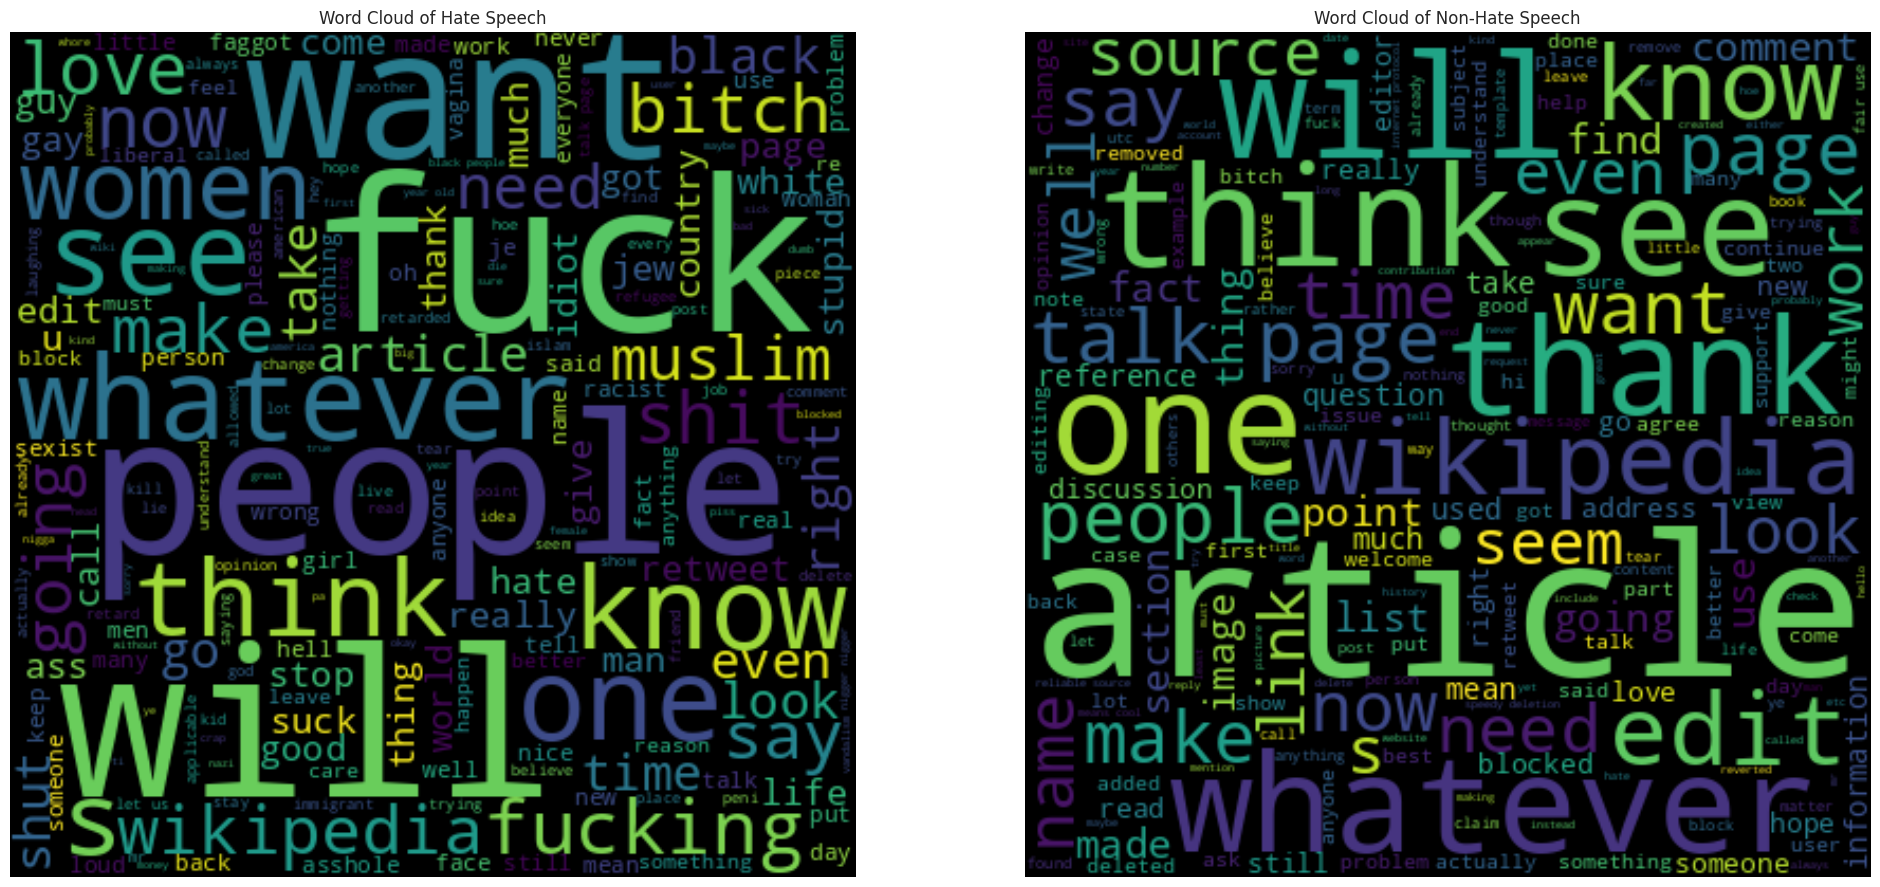

In [14]:
hs_words = ' '.join([word for word in tweet_df['Content'][tweet_df['Label']=='1']])
nonhs_words = ' '.join([word for word in tweet_df['Content'][tweet_df['Label']=='0']])

hate_speech_wordcloud = WordCloud(width=400, height=400, max_font_size=100).generate(hs_words)
non_hate_speech_wordcloud = WordCloud(width=400, height=400, max_font_size=100).generate(nonhs_words)

plt.figure(figsize=(24, 20))

plt.subplot(1, 2, 1)
plt.imshow(hate_speech_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Hate Speech')

plt.subplot(1, 2, 2)
plt.imshow(non_hate_speech_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Non-Hate Speech')

plt.show()

## Number of Rows

In [15]:
print("Jumlah baris:", tweet_df.shape[0])
print("Jenis Label:", tweet_df['Label'].unique())

Jumlah baris: 384098
Jenis Label: ['1' '0' 'Label']


## Dataset Info and Describe

In [16]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384098 entries, 0 to 384097
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Content      384098 non-null  object
 1   Label        384098 non-null  object
 2   Content_int  384098 non-null  object
dtypes: object(3)
memory usage: 8.8+ MB


In [17]:
tweet_df.describe()

,Content,Label,Content_int
count,384098,384098,384098
unique,364412,3,364412
top,content,0,"[146715, 7139, 146714]"
freq,7,309759,7


> Melihat tabel diatas, bisa diambil bahwa terdapat content yang duplikat sekitar 20 ribu baris, dan label yang kelebihan

## Distribution of Data

Label
0        309759
1         74332
Label         7
Name: count, dtype: int64




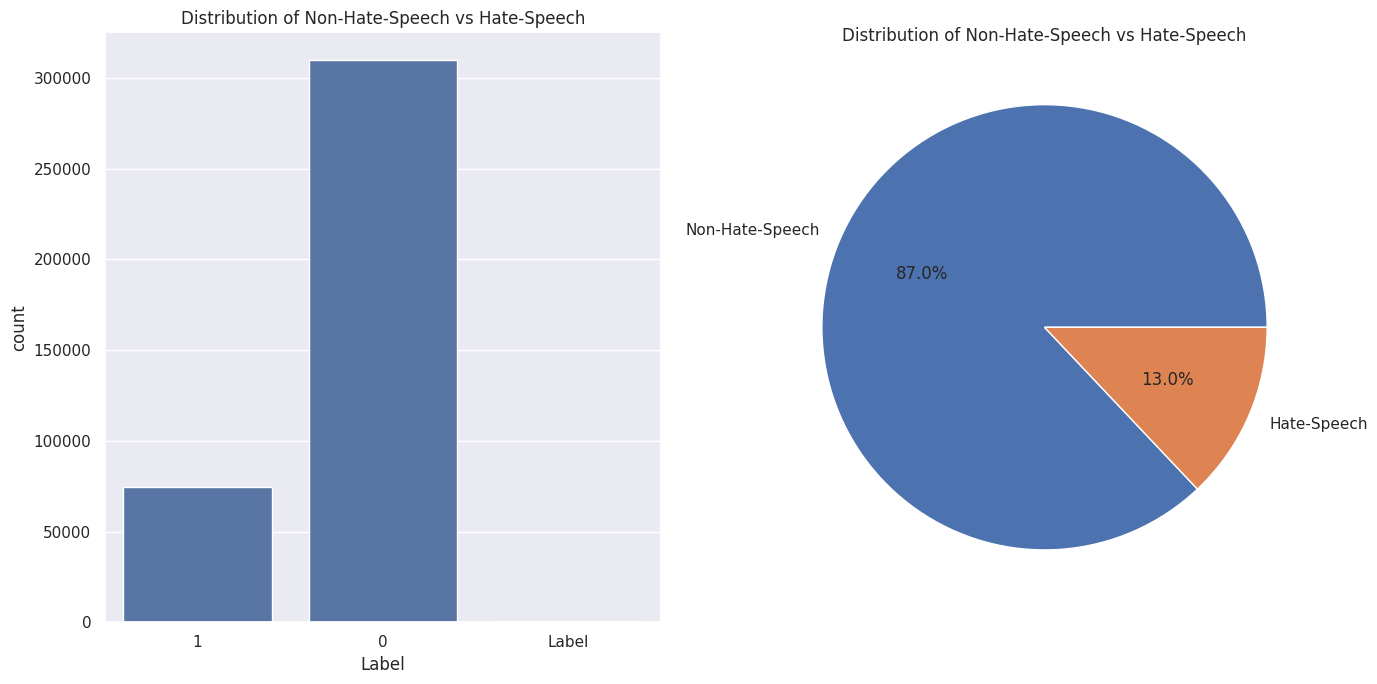

In [18]:
print(tweet_df['Label'].value_counts())
print('\n')

jum_Non_HS = tweet_df[tweet_df['Label']=='0']['Label'].count()
jum_HS = tweet_df[tweet_df['Label']=='1']['Label'].count()
percent_Non_HS = (jum_Non_HS/(jum_Non_HS+jum_HS)*100)
percent_HS= (jum_HS/(jum_Non_HS+jum_Non_HS))*100

fig, axs = plt.subplots(1, 2, figsize=(14, 7))

sns.countplot(x='Label', data=tweet_df, ax=axs[0])
axs[0].set_title('Distribution of Non-Hate-Speech vs Hate-Speech')


labels = ['Non-Hate-Speech', 'Hate-Speech']
sizes = [percent_Non_HS, percent_HS]
axs[1].pie(sizes, labels=labels, autopct='%1.1f%%')
axs[1].set_title('Distribution of Non-Hate-Speech vs Hate-Speech')

plt.tight_layout()
plt.show()

> Jika diperhatikan pada label 'Label', terdapat 7 content yang diberikan label ini sehingga harus dihapus dari dataset

## Check Duplicate and Conflict Data

In [19]:
print("Jumlah baris duplikat:", tweet_df.duplicated().sum())

Jumlah baris duplikat: 18835


In [20]:
grouped = tweet_df.groupby('Content')['Label'].nunique()
conflicted_contents = grouped[grouped > 1]

print("Contoh yang konflik:", conflicted_contents)
print("Total 'Content' dengan label yang berbeda:", conflicted_contents.count())

Contoh yang konflik: Content
a kitten for you because heavy is clearly a pussy that just tries to because trouble                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                2
a mes

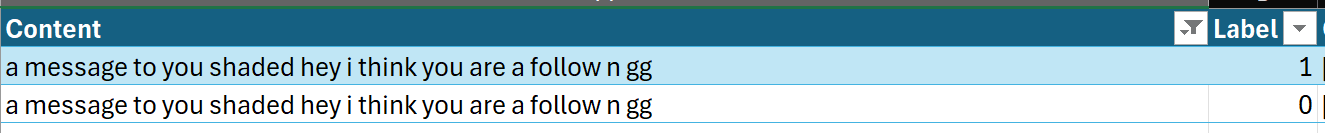

# Universal Preprocessing

## Remove "Content_int" Column

In [21]:
tweet_df = tweet_df.drop(columns=['Content_int'])
tweet_df.head()

,Content,Label
0,denial of normal the con be asked to comment o...,1
1,just by being able to tweet this insufferable ...,1
2,that is retarded you too cute to be single tha...,1
3,thought of a real badass mongol style declarat...,1
4,afro american basho,1


## Remove Labels Other Than 1 or 0

Jumlah baris 384091
Jenis Label: ['1' '0']
Axes(0.125,0.11;0.775x0.77)




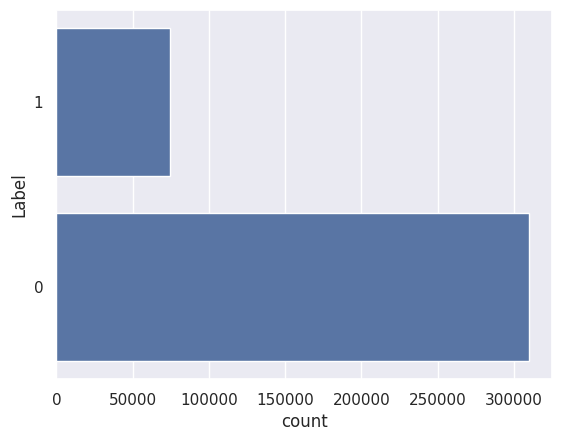

In [22]:
tweet_df = tweet_df[tweet_df['Label'] != 'Label']
print("Jumlah baris", tweet_df.shape[0])
print("Jenis Label:", tweet_df['Label'].unique())
print(sns.countplot(tweet_df['Label']))
print('\n')

## Drop Duplicate Row

In [23]:
tweet_df = tweet_df.drop_duplicates()
print("Jumlah baris duplikat:", tweet_df.duplicated().sum())

Jumlah baris duplikat: 0


## Drop Conflict Row


In [24]:
conflicted_content_list = conflicted_contents.index.tolist()
tweet_df = tweet_df[~tweet_df['Content'].isin(conflicted_content_list)]

grouped = tweet_df.groupby('Content')['Label'].nunique()
conflicted_contents = grouped[grouped > 1]
print("Total 'Content' dengan label yang berbeda:", conflicted_contents.count())

Total 'Content' dengan label yang berbeda: 0


## Handle Imbalance Class

In [25]:
print("Distribusi label sebelum undersampling:")
print(tweet_df['Label'].value_counts())

rus = RandomUnderSampler(random_state=42)
content_resampled, labels_resampled = rus.fit_resample(tweet_df[['Content']], tweet_df['Label'])

print("\nDistribusi label setelah undersampling:")
print(pd.Series(labels_resampled).value_counts())

tweet_df_resampled = pd.DataFrame({'Content': content_resampled.squeeze(), 'Label': labels_resampled})

Distribusi label sebelum undersampling:
Label
0    292633
1     70927
Name: count, dtype: int64

Distribusi label setelah undersampling:
Label
0    70927
1    70927
Name: count, dtype: int64


## Fix Slang Word

In [26]:
def load_abbreviations(file_path):
    with open(file_path, 'r') as file:
        abbreviations = json.load(file)
    return abbreviations

abbreviations = load_abbreviations(ABBREVIATIONS_PATH)

def fix_slang(text):
    if isinstance(text, str):
        words = text.split()
        fixed_words = [abbreviations[word.lower()] if word.lower() in abbreviations else word for word in words]
        return ' '.join(fixed_words)
    return text

tweet_df_resampled['Fix_Slang'] = tweet_df_resampled['Content'].apply(fix_slang)
tweet_df_resampled.head()

,Content,Label,Fix_Slang
0,you currently appear to be engaged in an edit ...,0,you currently appear to be engaged in an edit ...
1,i do not know why you people think america wil...,0,i do not know why you people think america wil...
2,full protection of article excessive i have be...,0,full protection of article excessive i have be...
3,i added rows to the popular vote table to refl...,0,i added rows to the popular vote table to refl...
4,arbor notification as you participated in the ...,0,arbor notification as you participated in the ...


## Fix Typo

In [27]:
spell = SpellChecker()

def correct_typos(text):
    corrected_text = []
    for word in text.split():
        corrected_word = spell.correction(word)
        corrected_text.append(corrected_word)
    return ' '.join(corrected_text)

tweet_df_resampled['Fix_Typo'] = tweet_df_resampled['Fix_Slang'].apply(fix_slang)
tweet_df_resampled.head()

,Content,Label,Fix_Slang,Fix_Typo
0,you currently appear to be engaged in an edit ...,0,you currently appear to be engaged in an edit ...,you currently appear to be engaged in an edit ...
1,i do not know why you people think america wil...,0,i do not know why you people think america wil...,i do not know why you people think america wil...
2,full protection of article excessive i have be...,0,full protection of article excessive i have be...,full protection of article excessive i have be...
3,i added rows to the popular vote table to refl...,0,i added rows to the popular vote table to refl...,i added rows to the popular vote table to refl...
4,arbor notification as you participated in the ...,0,arbor notification as you participated in the ...,arbor notification as you participated in the ...


## Clean Text

In [28]:
def clean_text(text):
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub('\n', '', text)
    text = re.sub('RT', '', text)
    text = re.sub("[^a-zA-Z^']", " ", text)
    text = re.sub(" {2,}", " ", text)
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    text = text.lower()
    return text

def case_folding(data):
    temp_tweet = []
    for tw in data:
        tw = clean_text(tw)
        temp_tweet.append(tw)
    return temp_tweet

tweet_df_resampled['Case_folded']=case_folding(tweet_df_resampled['Fix_Typo'])
tweet_df_resampled.head()

,Content,Label,Fix_Slang,Fix_Typo,Case_folded
0,you currently appear to be engaged in an edit ...,0,you currently appear to be engaged in an edit ...,you currently appear to be engaged in an edit ...,you currently appear to be engaged in an edit ...
1,i do not know why you people think america wil...,0,i do not know why you people think america wil...,i do not know why you people think america wil...,i do not know why you people think america wil...
2,full protection of article excessive i have be...,0,full protection of article excessive i have be...,full protection of article excessive i have be...,full protection of article excessive i have be...
3,i added rows to the popular vote table to refl...,0,i added rows to the popular vote table to refl...,i added rows to the popular vote table to refl...,i added rows to the popular vote table to refl...
4,arbor notification as you participated in the ...,0,arbor notification as you participated in the ...,arbor notification as you participated in the ...,arbor notification as you participated in the ...


## Tokenize

In [29]:
def tokenize_text(text):
    return word_tokenize(text)

tweet_df_resampled['Tokenized'] = tweet_df_resampled['Fix_Typo'].apply(tokenize_text)
tweet_df_resampled.head()

,Content,Label,Fix_Slang,Fix_Typo,Case_folded,Tokenized
0,you currently appear to be engaged in an edit ...,0,you currently appear to be engaged in an edit ...,you currently appear to be engaged in an edit ...,you currently appear to be engaged in an edit ...,"[you, currently, appear, to, be, engaged, in, ..."
1,i do not know why you people think america wil...,0,i do not know why you people think america wil...,i do not know why you people think america wil...,i do not know why you people think america wil...,"[i, do, not, know, why, you, people, think, am..."
2,full protection of article excessive i have be...,0,full protection of article excessive i have be...,full protection of article excessive i have be...,full protection of article excessive i have be...,"[full, protection, of, article, excessive, i, ..."
3,i added rows to the popular vote table to refl...,0,i added rows to the popular vote table to refl...,i added rows to the popular vote table to refl...,i added rows to the popular vote table to refl...,"[i, added, rows, to, the, popular, vote, table..."
4,arbor notification as you participated in the ...,0,arbor notification as you participated in the ...,arbor notification as you participated in the ...,arbor notification as you participated in the ...,"[arbor, notification, as, you, participated, i..."


## Lemmatizing

In [30]:
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(token_list):
    return [lemmatizer.lemmatize(token) for token in token_list]

tweet_df_resampled['Lemma'] = tweet_df_resampled['Tokenized'].apply(lemmatize_tokens)
tweet_df_resampled.head()

,Content,Label,Fix_Slang,Fix_Typo,Case_folded,Tokenized,Lemma
0,you currently appear to be engaged in an edit ...,0,you currently appear to be engaged in an edit ...,you currently appear to be engaged in an edit ...,you currently appear to be engaged in an edit ...,"[you, currently, appear, to, be, engaged, in, ...","[you, currently, appear, to, be, engaged, in, ..."
1,i do not know why you people think america wil...,0,i do not know why you people think america wil...,i do not know why you people think america wil...,i do not know why you people think america wil...,"[i, do, not, know, why, you, people, think, am...","[i, do, not, know, why, you, people, think, am..."
2,full protection of article excessive i have be...,0,full protection of article excessive i have be...,full protection of article excessive i have be...,full protection of article excessive i have be...,"[full, protection, of, article, excessive, i, ...","[full, protection, of, article, excessive, i, ..."
3,i added rows to the popular vote table to refl...,0,i added rows to the popular vote table to refl...,i added rows to the popular vote table to refl...,i added rows to the popular vote table to refl...,"[i, added, rows, to, the, popular, vote, table...","[i, added, row, to, the, popular, vote, table,..."
4,arbor notification as you participated in the ...,0,arbor notification as you participated in the ...,arbor notification as you participated in the ...,arbor notification as you participated in the ...,"[arbor, notification, as, you, participated, i...","[arbor, notification, a, you, participated, in..."


## Remove Stopwords

In [31]:
eng_stopwords = stopwords.words('english')

def remove_stopwords(token_list):
    return [word for word in token_list if word not in eng_stopwords]

tweet_df_resampled['No_StopWord'] = tweet_df_resampled['Lemma'].apply(remove_stopwords)
tweet_df_resampled.head()

,Content,Label,Fix_Slang,Fix_Typo,Case_folded,Tokenized,Lemma,No_StopWord
0,you currently appear to be engaged in an edit ...,0,you currently appear to be engaged in an edit ...,you currently appear to be engaged in an edit ...,you currently appear to be engaged in an edit ...,"[you, currently, appear, to, be, engaged, in, ...","[you, currently, appear, to, be, engaged, in, ...","[currently, appear, engaged, edit, war, accord..."
1,i do not know why you people think america wil...,0,i do not know why you people think america wil...,i do not know why you people think america wil...,i do not know why you people think america wil...,"[i, do, not, know, why, you, people, think, am...","[i, do, not, know, why, you, people, think, am...","[know, people, think, america, change, always,..."
2,full protection of article excessive i have be...,0,full protection of article excessive i have be...,full protection of article excessive i have be...,full protection of article excessive i have be...,"[full, protection, of, article, excessive, i, ...","[full, protection, of, article, excessive, i, ...","[full, protection, article, excessive, wikiped..."
3,i added rows to the popular vote table to refl...,0,i added rows to the popular vote table to refl...,i added rows to the popular vote table to refl...,i added rows to the popular vote table to refl...,"[i, added, rows, to, the, popular, vote, table...","[i, added, row, to, the, popular, vote, table,...","[added, row, popular, vote, table, reflect, es..."
4,arbor notification as you participated in the ...,0,arbor notification as you participated in the ...,arbor notification as you participated in the ...,arbor notification as you participated in the ...,"[arbor, notification, as, you, participated, i...","[arbor, notification, a, you, participated, in...","[arbor, notification, participated, eye, threa..."


## Combine To One String

In [32]:
tweet_df_resampled['Clean'] = tweet_df_resampled['No_StopWord'].apply(lambda x: ' '.join(x))
tweet_df_resampled.head()

,Content,Label,Fix_Slang,Fix_Typo,Case_folded,Tokenized,Lemma,No_StopWord,Clean
0,you currently appear to be engaged in an edit ...,0,you currently appear to be engaged in an edit ...,you currently appear to be engaged in an edit ...,you currently appear to be engaged in an edit ...,"[you, currently, appear, to, be, engaged, in, ...","[you, currently, appear, to, be, engaged, in, ...","[currently, appear, engaged, edit, war, accord...",currently appear engaged edit war according re...
1,i do not know why you people think america wil...,0,i do not know why you people think america wil...,i do not know why you people think america wil...,i do not know why you people think america wil...,"[i, do, not, know, why, you, people, think, am...","[i, do, not, know, why, you, people, think, am...","[know, people, think, america, change, always,...",know people think america change always racist...
2,full protection of article excessive i have be...,0,full protection of article excessive i have be...,full protection of article excessive i have be...,full protection of article excessive i have be...,"[full, protection, of, article, excessive, i, ...","[full, protection, of, article, excessive, i, ...","[full, protection, article, excessive, wikiped...",full protection article excessive wikipedia tw...
3,i added rows to the popular vote table to refl...,0,i added rows to the popular vote table to refl...,i added rows to the popular vote table to refl...,i added rows to the popular vote table to refl...,"[i, added, rows, to, the, popular, vote, table...","[i, added, row, to, the, popular, vote, table,...","[added, row, popular, vote, table, reflect, es...",added row popular vote table reflect estimate ...
4,arbor notification as you participated in the ...,0,arbor notification as you participated in the ...,arbor notification as you participated in the ...,arbor notification as you participated in the ...,"[arbor, notification, as, you, participated, i...","[arbor, notification, a, you, participated, in...","[arbor, notification, participated, eye, threa...",arbor notification participated eye thread led...


## Combining Cleaned Text and Labels to New DF

In [33]:
dataset = tweet_df_resampled[['Clean', 'Label']].copy()
dataset['Label'] = pd.to_numeric(dataset['Label'])
dataset.head()

,Clean,Label
0,currently appear engaged edit war according re...,0
1,know people think america change always racist...,0
2,full protection article excessive wikipedia tw...,0
3,added row popular vote table reflect estimate ...,0
4,arbor notification participated eye thread led...,0


In [34]:
print(dataset.shape)

(141854, 2)


# Export to new dataset

In [35]:
dataset.to_csv('/content/drive/MyDrive/Kuliah/Semester 4/NLP/dataset/Preprocessing_HateSpeechDataset.csv', index=False)